# ROOSTER training framework (MSAP4-03)

This notebook provide an example of the analysis of a set of stars with catalog-existing reference $P_\mathrm{rot}$, and use the set to train an instance of ROOSTER.

First we need to import the demonstrator module and the auxiliary module containing the dataset we are going to work with.

**Note:** This notebook has been designed for the purpose of scientific justification of PLATO MSAP4-03. The notebook illustrated the precise flowchart envisaged for PLATO MSAP4-03 is cs_rooster_sph_analysis.ipynb

In [1]:
import star_privateer as sp
import plato_msap4_demonstrator_datasets.kepler_dataset as kepler_dataset

In [2]:
sp.__version__

'1.1.1'

We also need to import some other modules to run the notebook and to check that the outputs directory that we need exist. In addition to `star_privateer` requirements, you should make sure that the [`pathos` module](https://pathos.readthedocs.io/en/latest/index.html) is installed in order to run the analysis in parallel.

In [3]:
import os, pathos
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

if not os.path.exists ('rooster_training_features') :
    os.mkdir ('rooster_training_features')
if not os.path.exists ('rooster_instances') :
    os.mkdir ('rooster_instances')

## Running the analysis pipeline

We are going to work with a sample of 1991 *Kepler* stars analysed by Santos et al. (2019, 2021). The light curves have been calibrated with the KEPSEISMIC method (see García et al. 2011, 2014), and all of them have been filtered with a 55-day high-pass filter. We can get the identifiers of the stars in the dataset with the following instruction:

In [4]:
list_kic = sp.get_list_targets (kepler_dataset)

The next step is to run the analysis pipeline on every light curve in the dataset. The analysis pipeline in its default behaviour will compute the Lomb-Scargle periodogram (LSP) of the light curve as well as its auto-correlation function (ACF). ACF and LSP will then be used to compute a composite spectrum (CS), obtained by multiplying one by another. The feature computed for each stars are stored in a dedicated csv file identified by the star identifier (in this case, the KIC of the star). We are going to parallelise the analysis process with `pathos` in order to gain some computation time and control memory leakages that could arise from calling `analysis_pipeline` in a loop.

In [5]:
def analysis_wrapper (kic) :
    """
    Analysis wrapper to speed computation
    by parallelising process and control
    memory usage.
    """
    str_kic = str (kic).zfill (9)
    filename = sp.get_target_filename (kepler_dataset, str_kic)
    fileout = 'rooster_training_features/{}.csv'.format(str_kic)
    fileplot = 'rooster_training_features/{}.png'.format(str_kic)
    if not os.path.exists (fileout) :
        t, s, dt = sp.load_resource (filename)
        (p_ps, p_acf, 
         ps, acf, 
         cs, features, 
         feature_names, 
         fig) = sp.analysis_pipeline (t, s, pmin=0.1, pmax=60,
                                      wavelet_analysis=False, plot=True,
                                      filename=fileplot, figsize=(10,16), 
                                      lw=1, dpi=300)
        df = sp.save_features (fileout, kic, features, feature_names)
        plt.close ("all")

Now that are wrapper function is defined, we just create a `ProcessPool` that we run with `imap`:

> Note: by default `imap`, on the contrary to `map`, is a non-blocking process. Nevertheless, in order to display a progress bar with `tqdm` we need to use it, and the `list` encapsulation is there to ensure the process is blocking.

In [6]:
process_pool = pathos.pools._ProcessPool (processes=4, 
                                          maxtasksperchild=10)
with process_pool as p :
    list (tqdm (p.imap (analysis_wrapper,
                        list_kic,
                        ),
                total=len (list_kic))
          )
    p.close ()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1991/1991 [00:02<00:00, 813.84it/s]


After running the analysis pipeline, it is possible to concatenate the feature obtained for each star into one big DataFrame.

In [7]:
df = sp.build_catalog_features ('rooster_training_features')

This is typically what the DataFrame is going to look like:

In [8]:
df

,prot_ps,prot_acf,prot_cs,e_prot_ps,E_prot_ps,e_prot_acf,E_prot_acf,e_prot_cs,E_prot_cs,sph_ps,sph_acf,sph_cs,h_ps,fa_prob_ps,hacf,gacf,hcs
target_id,,,,,,,,,,,,,,,,,
891901,72.869400,51.574947,5.641531,11.498762,16.801211,-1.0,-1.0,0.013099,0.013099,784.128871,773.889578,620.957800,6.840314e+04,0.0,0.277619,0.109637,0.122620
1162339,73.786255,78.690215,-1.000000,9.241541,12.330192,-1.0,-1.0,-1.000000,-1.000000,2264.578879,2190.576851,-1.000000,8.107581e+05,0.0,0.864250,0.429628,0.911895
1163248,72.325512,59.625771,31.106914,10.129668,14.071197,-1.0,-1.0,0.461511,0.461511,541.792440,541.775945,536.567054,1.771122e+04,0.0,0.271948,0.135494,0.242804
1164583,49.879590,43.891695,46.649025,9.570083,15.528976,-1.0,-1.0,5.788649,5.788649,1650.038075,1642.510883,1699.105727,1.188174e+05,0.0,0.635193,0.317102,0.470231
1433067,73.786360,83.226618,47.031942,13.608601,21.562106,-1.0,-1.0,1.743351,1.743351,1220.871088,1261.758571,1197.588777,3.545902e+04,0.0,0.348045,0.222222,0.142060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12647815,10.332284,10.421169,10.439065,0.916122,1.113599,-1.0,-1.0,0.052547,0.052547,4731.203891,4731.485721,4725.580181,1.736751e+06,0.0,0.993603,0.606440,0.928364
12737258,40.694822,77.607082,40.528748,3.924354,4.862094,-1.0,-1.0,0.874980,0.874980,2129.783908,2155.527066,2138.397742,4.015526e+05,0.0,0.675193,0.421634,3.076674
12784167,18.391466,12.709734,46.124761,2.039831,2.621296,-1.0,-1.0,1.764008,1.764008,631.230913,615.325577,642.343757,1.074141e+04,0.0,0.000056,0.082313,2.219790


In [9]:
df.to_csv ("training_features.csv")

## Training and testing ROOSTER

Now that we have analysed a large sample of stars, we are able to use it to train the random forest ROOSTER methodology (see Breton et al. 2021). First, let's (arbitrarily) divide our DataFrame into a training set and a test set.

In [10]:
df_train = df.loc[df.index[::2]]
df_test = df.loc[df.index[1::2]]

The DataFrames let us obtain all the input we require to train and test ROOSTER:

In [11]:
(training_id, training_p_candidates, 
 training_features, feature_names) = sp.create_rooster_feature_inputs (df_train)
(test_id, test_p_candidates, 
 test_features, test_feature_names) = sp.create_rooster_feature_inputs (df_test)

Now, let's instantiate a new ROOSTER object. The main attributes of ROOSTER are its two random forest classifiers, ``RotClass`` and ``PeriodSel``. The properties of these classifiers can be specified by the user by passing the optional arguments of ``sklearn.ensemble.RandomForestClassifier`` to the created ROOSTER instance. 

In [12]:
seed = 104359357
chicken = sp.ROOSTER (n_estimators=100, random_state=np.random.RandomState (seed=seed))
chicken.RotClass, chicken.PeriodSel

(RandomForestClassifier(random_state=RandomState(MT19937) at 0x13483C440),
 RandomForestClassifier(random_state=RandomState(MT19937) at 0x13483C440))

The training is performed as follows:

In [13]:
chicken.train (training_id, training_p_candidates,
               training_features, feature_names=feature_names,
               catalog='santos-19-21', verbose=True)

Training RotClass with 390 stars with detected rotation and 494 without detected rotation.
Training PeriodSel with 390 stars.


Once properly trained, ROOSTER performances can be assessed with our test set:

In [14]:
results = chicken.test (test_id, test_p_candidates, test_features, 
                        feature_names=test_feature_names, 
                        catalog='santos-19-21', verbose=True)

Testing RotClass with 394 stars with detected rotation and 501 without detected rotation.
Testing PeriodSel with 394 stars.


The score obtained during the test set can be accessed through the ``getScore`` function, as well as the number of elements used for the training and the test steps. 

In [15]:
chicken.getScore ()

(0.9329608938547486, 0.9238578680203046)

In [16]:
chicken.getNumberEltTrain ()

(884, 390)

In [17]:
chicken.getNumberEltTest ()

(895, 394)

The $P_\mathrm{rot}$ computed by ROOSTER for the test set are returned when calling the function and it can be interesting to plot the distribution to compare it to the reference catalog values. 

In [18]:
prot_rooster = results[3]
prot_ref = sp.get_prot_ref (results[2], catalog='santos-19-21')

Let's take a look at the corresponding histogram

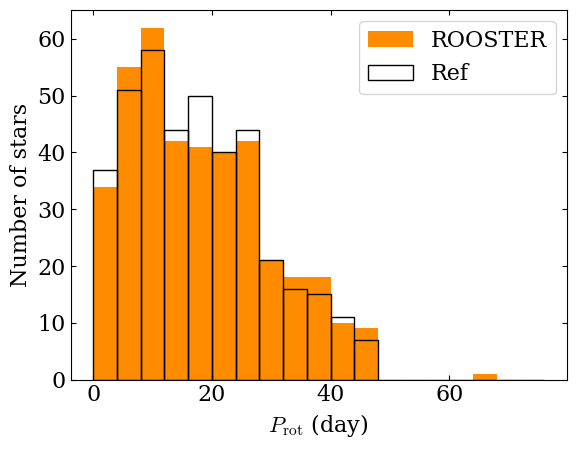

In [19]:
fig, ax = plt.subplots (1, 1)

bins = np.linspace (0, 80, 20, endpoint=False)

ax.hist (prot_rooster, bins=bins, color='darkorange', label='ROOSTER')
ax.hist (prot_ref, bins=bins, facecolor='none',
        edgecolor='black', label='Ref')

ax.set_xlabel (r'$P_\mathrm{rot}$ (day)')
ax.set_ylabel (r'Number of stars')

ax.legend ()

Finally, let's save our trained ROOSTER instance to be able to use it again later (for example in the next tutorial notebook !)

In [20]:
chicken.save ('rooster_instances/rooster_tutorial')